# Where Convergent Cross-Mapping Fails
October 13, 2024

Convergent Cross-mapping (CCM) is a technique for causal inference in dynamical systems. CCM claims to infer cause and effect directionality given two time series $X$ and $Y$. The [2012 paper of Sugihara et al](https://www.science.org/doi/10.1126/science.1227079) introduced CCM and they showed that for a deterministic "coupled" chaotic system where $X$ influences $Y$ and vice versa by some degree, CCM is able to infer the strength of effect. (For a more in depth background about CCM and how it works, see Chapter 6 of our online [Time Series Handbook](https://phdinds-aim.github.io/time_series_handbook/06_ConvergentCrossMappingandSugiharaCausality/ccm_sugihara.html).)

Hundreds of papers have since used CCM to infer causal direction in ecosystems and other natural systems. In our [2022 paper](https://www.sciencedirect.com/science/article/abs/pii/S0378437122005738), we used CCM to infer possible causal relations among factors in a water dam system.

However, because CCM is built with the assumption of a determinstic coupled chaotic dynamical system, it's natural to ask, "how applicable is CCM for time series data that come from systems that violate the assumption of CCM?"

In this article we investigate the ability of CCM to infer directionality between two observed time series variables on different classes of functions:
1. Deterministic Chaotic Systems - we investigate the effect of the presence of hidden confounding variables
2. Chaotic Systems with Random Noise - here, the system is no longer fully deterministic. 
3. Additive Noise Models (ANMs) - standard model for Structural Causal Models of the form $Y = f(X) + N_X$ where $N_X$ is an independent random noise. We use non-linear Gaussian models. Linear Gaussian models have been shown to be unidentifiable (we cannot infer directionality of causation) unless the variances of the noise are all equal. (See the works of Scholkopf, Peters, Janzing, Pearl).

We summarize our findings below. 

||variable relations |causal graph|$X \rightarrow Y$|$Y \rightarrow X$|$Z \rightarrow X$|$Z \rightarrow Y$|$X \rightarrow Z$|$Y \rightarrow Z$|
|--|--|--|:--:|:--:|:--:|:--:|:--:|:--:|
1|chaotic (deterministic)|$X \perp Y, Z_t \rightarrow X_{t+1}, Z_t \rightarrow Y_{t+2}$|✔|✔|✔|✔|✔|✔
2|chaotic (deterministic)|$X_t \rightarrow Y_{t+1}$, $Y_t \rightarrow X_{t+1}, X_t \rightarrow X_{t+1}$, $Y_t \rightarrow Y_{t+1}$|✔|✔|NA|NA|NA|NA
3|chaotic (deterministic)|$X_t \rightarrow Y_{t+1}$, $Y_t \rightarrow X_{t+1}$|✔|✔|NA|NA|NA|NA
4|chaotic (w/ noise)|$X \perp Y, Z_t \rightarrow X_{t+1}, Z_t \rightarrow Y_{t+2}$|✘|✔|✔|✔|✔|✘
5|chaotic (w/ noise)|$X_t \rightarrow Y_{t+1}$, $Y_t \rightarrow X_{t+1}, X_t \rightarrow X_{t+1}$, $Y_t \rightarrow Y_{t+1}$|✔|✔|NA|NA|NA|NA|
6|chaotic (w/ noise)|$X_t \rightarrow Y_{t+1}$, $Y_t \rightarrow X_{t+1}$|✔|✔|NA|NA|NA|NA
7|additive noise model|$X \perp Y, Z_t \rightarrow X_{t+1}, Z_t \rightarrow Y_{t+2}$|✔|✔|✘|✘|✘|✘
8|additive noise model|$X_t \rightarrow Y_{t+1}$, $Y_t \rightarrow X_{t+1}, X_t \rightarrow X_{t+1}$, $Y_t \rightarrow Y_{t+1}$|✘|✘|NA|NA|NA|NA|
9|additive noise model|$X_t \rightarrow Y_{t+1}$, $Y_t \rightarrow X_{t+1}$|✔|✔|NA|NA|NA|NA

We find that in the presence of a confounding variable in a chaotic system, CCM was able to infer the right causal directions. 

However, **once small Gaussian noise (standard deviation = 0.015) is added to the variables at each timestep, CCM fails to infer the right relationships between some variables** (item 4 in the table)

Similarly, **CCM fails to consistently infer the right causal relations if they are in the form of Additive Noise Models (ANMs).**

These results tell us that we should be careful when using CCM especially when the relations among variables do not follow a fully deterministic chaotic system. (We have yet to check for more kinds of causal graphs to investigate if CCM fails for some causal graphs even if chaotic.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from causal_ccm.causal_ccm import ccm
from tqdm import tqdm

In [13]:
def viz_ccm(func, X, Y, L_range, tau, E, X_name="X", Y_name="Y", ax=None):
    Xhat_My, Yhat_Mx = [], [] # correlation list
    for L in L_range: 
        ccm_XY = func(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
        ccm_YX = func(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    

        # lowest value must be 0 -- following the process of the original paper
        # implement this in the package as an option
        rho_xy = np.max([0, ccm_XY.causality()[0]])
        rho_yx = np.max([0, ccm_YX.causality()[0]])

        Xhat_My.append(rho_xy) 
        Yhat_Mx.append(rho_yx) 

    if ax is not None:
        # plot convergence as L->inf. Convergence is necessary to conclude causality
        ax.plot(L_range, Xhat_My, label=f'{X_name} --> {Y_name}', linewidth=2)
        ax.plot(L_range, Yhat_Mx, c='r', label=f'{Y_name} --> {X_name}', linewidth=2)
        ax.set_xlabel('L', size=10)
        ax.set_ylabel('correl', size=10)
        ax.legend(prop={'size': 15})
        ax.set_title(f"E={E}")
    
    return None

## Chaotic Models

First we define our chaotic system builder. The chaotic function follows this form: 

$A = A  (r - r  A - \beta  B)$

Where $\beta$ is the strength of effect of $B$ on $A$

In [ ]:
def chaotic_func(A, B, r, beta):
    return A * (r - r * A - beta * B)

### Example 1
We define a coupled chaotic function among three time series $X$, $Y$, and $Z$. But only $X$ and $Y$ are observed. We visualize below the relationships among the variables. In this case, $Z_t \rightarrow X_{t+1}$ and $Z_t \rightarrow Y_{t+2}$ but there is no causal relation between $X$ and $Y$.

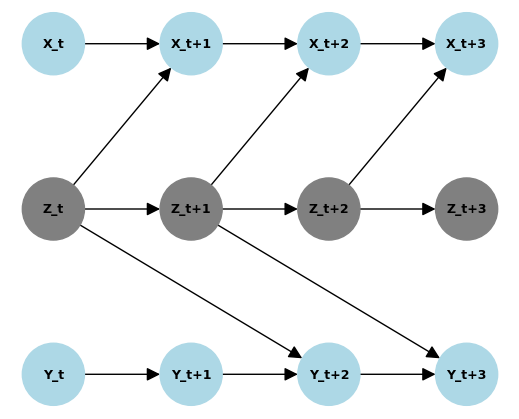

In [3]:
# Create a new directed graph for the updated visualization
def draw():
    G = nx.DiGraph()

    # Re-adding nodes for time steps t to t+3
    # X and Y are visible, Z is hidden but without the "hidden" label
    nodes = ['X_t', 'X_t+1', 'X_t+2', 'X_t+3',
            'Y_t', 'Y_t+1', 'Y_t+2', 'Y_t+3',
            'Z_t', 'Z_t+1', 'Z_t+2', 'Z_t+3']

    # Re-adding directed edges according to the SCM
    edges = [
        # X time series
        ('X_t', 'X_t+1'), ('X_t+1', 'X_t+2'), ('X_t+2', 'X_t+3'),
        # Y time series
        ('Y_t', 'Y_t+1'), ('Y_t+1', 'Y_t+2'), ('Y_t+2', 'Y_t+3'),
        # Hidden Z time series
        ('Z_t', 'Z_t+1'), ('Z_t+1', 'Z_t+2'), ('Z_t+2', 'Z_t+3'),
        # Hidden Z affecting X and Y
        ('Z_t', 'X_t+1'), ('Z_t+1', 'X_t+2'), ('Z_t+2', 'X_t+3'),
        ('Z_t', 'Y_t+2'), ('Z_t+1', 'Y_t+3')
    ]

    # Add nodes and edges to the graph
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # Set positions to place Z nodes in the middle of X and Y, spaced out for time steps
    pos = {
        'X_t': (0, 3), 'X_t+1': (2, 3), 'X_t+2': (4, 3), 'X_t+3': (6, 3),
        'Y_t': (0, 1), 'Y_t+1': (2, 1), 'Y_t+2': (4, 1), 'Y_t+3': (6, 1),
        'Z_t': (0, 2), 'Z_t+1': (2, 2), 'Z_t+2': (4, 2), 'Z_t+3': (6, 2)
    }

    # Assign lighter blue for X and Y, gray for Z
    node_colors = ['lightblue' if 'X' in node or 'Y' in node else 'gray' for node in G.nodes]

    # Draw the graph with lighter blue for X and Y, gray for Z
    plt.figure(figsize=(5, 4))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=9, font_weight='bold', arrowsize=20)

    # Display the plot
    plt.show()

draw()

We define a determinsitic coupled chaotic system as follows:

In [7]:
# Based on Supplementary Materials https://www.science.org/doi/10.1126/science.1227079
# params
r_x = 3.4
r_y = 3.6
r_z = 3.8
B_xy = 0.0 # effect on x given y (effect of y on x)
B_yx = 0.0 # effect on y given x (effect of x on y)
B_yz = 0.2 # effect of z on y
B_xz = 0.2 # effect of z on x

X0 = 0.3 # initial val following Sugihara et al
Y0 = 0.3 # initial val following Sugihara et al
Z0 = 0.3
t = 2000 # time steps

X = [X0, X0]
Y = [Y0, Y0]
Z = [Z0, Z0]
for i in range(t):
    Z_ = chaotic_func(Z[-1], 0, r_z, 0)    
    X_ = chaotic_func(X[-1], Z[-1], r_x, B_xz)
    Y_ = chaotic_func(Y[-1], Z[-2], r_y, B_yz)
    X.append(X_)
    Y.append(Y_)
    Z.append(Z_)

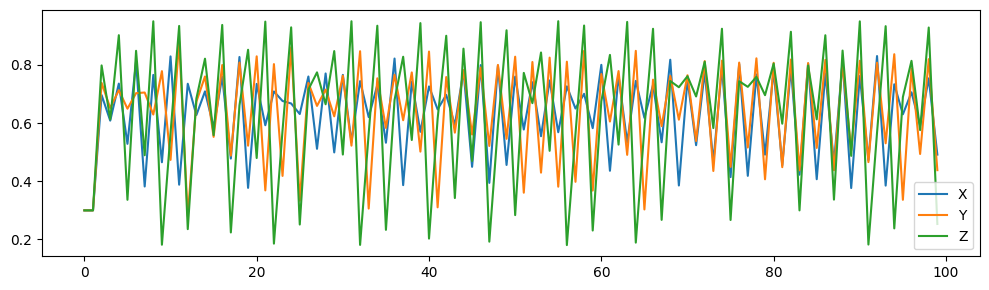

In [8]:
plt.figure(figsize=(10, 3))
plt.plot(X[:100], label="X")
plt.plot(Y[:100], label = "Y")
plt.plot(Z[:100], label = "Z")
plt.legend()
plt.tight_layout()
plt.show()

Here, we see clearly that there is no convergence of cross-mapping correlations. In this case, CCM correctly inferred that there is no causal link between $X$ and $Y$.

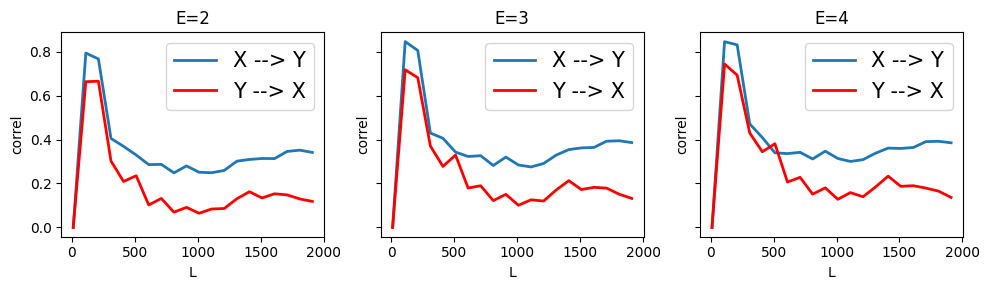

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, X, Y, L_range, tau, E, X_name='X', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()

Can CCM infer that $Z \rightarrow X$? We can see below that yes, it can.

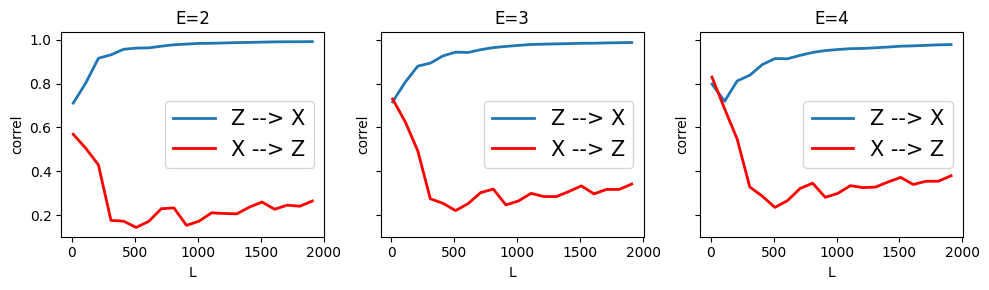

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, Z, X, L_range, tau, E, X_name='Z', Y_name='X', ax=axs[i])
plt.tight_layout()
plt.show()    

Similarly, CCM can infer that $Z \rightarrow Y$

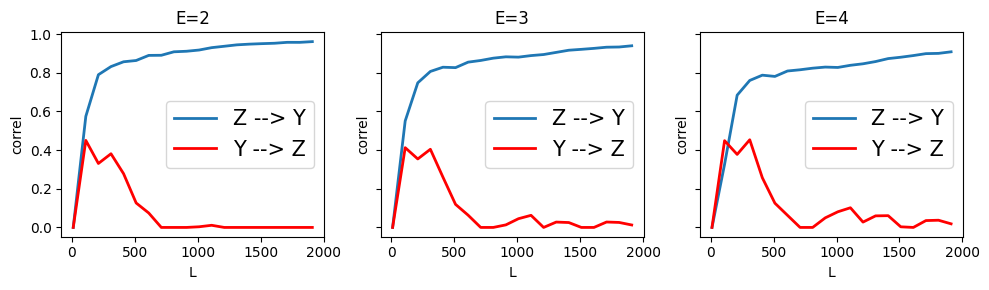

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, Z, Y, L_range, tau, E, X_name='Z', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()    

### Example 2

In this case, $X_t \rightarrow Y_{t+1}$ and $Y_t \rightarrow X_{t+1}$ but also $X_t \rightarrow X_{t+1}$ and $Y_t \rightarrow Y_{t+1}$. We make the effect of $X$ on $Y$ stronger than $Y$ on $X$.

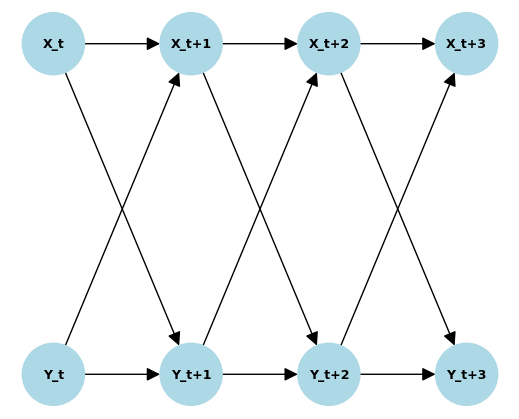

In [21]:
def draw():

    # Create a new directed graph with additional self-dependencies for X and Y
    G_modified = nx.DiGraph()

    # Re-adding nodes for time steps t to t+3 for X and Y
    nodes_modified = ['X_t', 'X_t+1', 'X_t+2', 'X_t+3',
                    'Y_t', 'Y_t+1', 'Y_t+2', 'Y_t+3']

    # Adding directed edges according to the modified relations for t to t+3
    edges_modified = [
        # X to Y relations
        ('X_t', 'Y_t+1'), ('X_t+1', 'Y_t+2'), ('X_t+2', 'Y_t+3'),
        # Y to X relations
        ('Y_t', 'X_t+1'), ('Y_t+1', 'X_t+2'), ('Y_t+2', 'X_t+3'),
        # Self-dependencies for X and Y
        ('X_t', 'X_t+1'), ('X_t+1', 'X_t+2'), ('X_t+2', 'X_t+3'),
        ('Y_t', 'Y_t+1'), ('Y_t+1', 'Y_t+2'), ('Y_t+2', 'Y_t+3')
    ]

    # Add nodes and edges to the graph
    G_modified.add_nodes_from(nodes_modified)
    G_modified.add_edges_from(edges_modified)

    # Set positions for a clearer layout, spaced out for time steps
    pos_modified = {
        'X_t': (0, 2), 'X_t+1': (2, 2), 'X_t+2': (4, 2), 'X_t+3': (6, 2),
        'Y_t': (0, 1), 'Y_t+1': (2, 1), 'Y_t+2': (4, 1), 'Y_t+3': (6, 1)
    }

    # Assign colors: blue for both X and Y
    node_colors_modified = ['lightblue' for node in G_modified.nodes]

    # Draw the modified graph with additional self-dependencies
    plt.figure(figsize=(5, 4))
    nx.draw(G_modified, pos_modified, with_labels=True, node_size=2000, node_color=node_colors_modified, font_size=9, font_weight='bold', arrowsize=20)

    # Display the plot
    plt.show()

draw()

In [27]:
# params
r_x = 3.4
r_y = 3.6
B_xy = 0.1 # effect on x given y (effect of y on x)
B_yx = 0.4 # effect on y given x (effect of x on y)

X0 = 0.3 # initial val following Sugihara et al
Y0 = 0.3 # initial val following Sugihara et al
t = 2000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = chaotic_func(X[-1], Y[-1], r_x, B_xy)
    Y_ = chaotic_func(Y[-1], X[-1], r_y, B_yx)
    X.append(X_)
    Y.append(Y_)

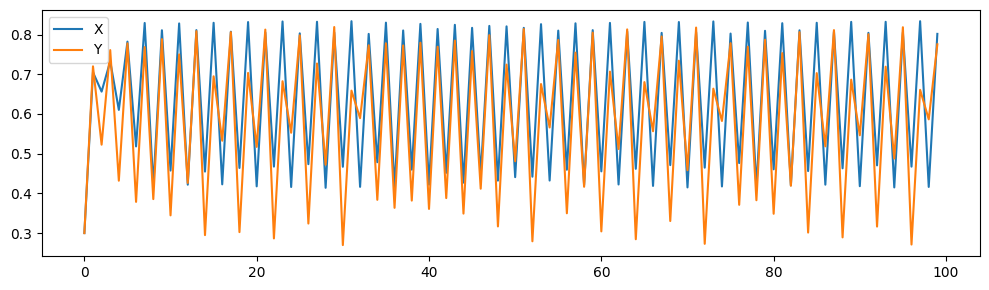

In [28]:
plt.figure(figsize=(10, 3))
plt.plot(X[:100], label="X")
plt.plot(Y[:100], label = "Y")
plt.legend()
plt.tight_layout()
plt.show()

Here we find that CCM was able to correctly infer the feedback loop and also the order of strength of effect, where $X$ has stronger effect on $Y$

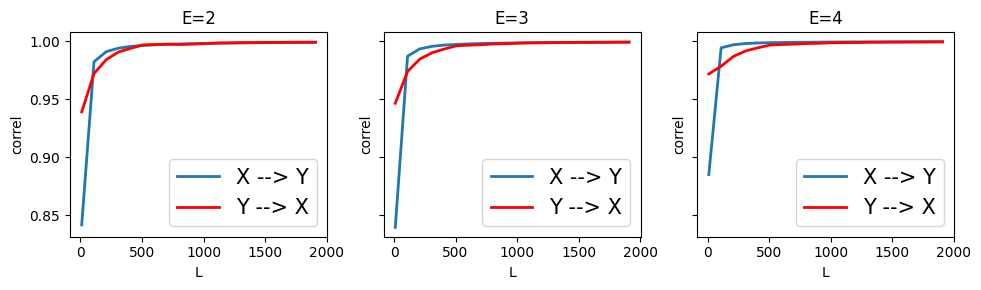

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, X, Y, L_range, tau, E, X_name='X', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()    

### Example 3

Here, we keep $X_t \rightarrow Y_{t+1}$ and $Y_t \rightarrow X_{t+1}$ but we remove $X_t \rightarrow X_{t+1}$ and $Y_t \rightarrow Y_{t+1}$. We make the effect of $X$ on $Y$ stronger than $Y$ on $X$.

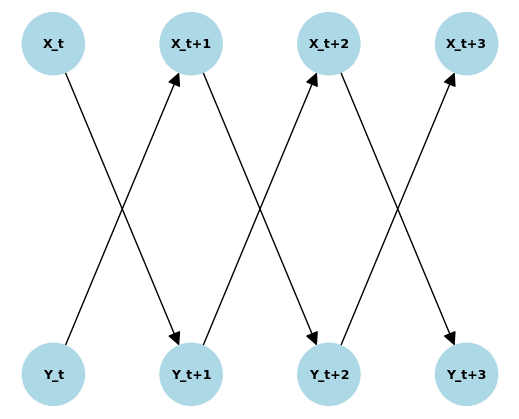

In [30]:
def draw():
    # Create a new directed graph for the extended time range t to t+3
    G_extended = nx.DiGraph()

    # Re-adding nodes for time steps t to t+3 for X and Y
    nodes_extended = ['X_t', 'X_t+1', 'X_t+2', 'X_t+3',
                    'Y_t', 'Y_t+1', 'Y_t+2', 'Y_t+3']

    # Adding directed edges according to the relations for t to t+3
    edges_extended = [
        # X to Y relations
        ('X_t', 'Y_t+1'), ('X_t+1', 'Y_t+2'), ('X_t+2', 'Y_t+3'),
        # Y to X relations
        ('Y_t', 'X_t+1'), ('Y_t+1', 'X_t+2'), ('Y_t+2', 'X_t+3')
    ]

    # Add nodes and edges to the graph
    G_extended.add_nodes_from(nodes_extended)
    G_extended.add_edges_from(edges_extended)

    # Set positions for a clearer layout, spaced out for time steps
    pos_extended = {
        'X_t': (0, 2), 'X_t+1': (2, 2), 'X_t+2': (4, 2), 'X_t+3': (6, 2),
        'Y_t': (0, 1), 'Y_t+1': (2, 1), 'Y_t+2': (4, 1), 'Y_t+3': (6, 1)
    }

    # Assign colors: blue for both X and Y
    node_colors_extended = ['lightblue' for node in G_extended.nodes]

    # Draw the extended graph
    plt.figure(figsize=(5, 4))
    nx.draw(G_extended, pos_extended, with_labels=True, node_size=2000, node_color=node_colors_extended, font_size=9, font_weight='bold', arrowsize=20)

    # Display the plot
    plt.show()

draw()

In [36]:
# params
r_x = 3.4
r_y = 3.6
B_xy = 0.1 # effect on x given y (effect of y on x)
B_yx = 0.4 # effect on y given x (effect of x on y)

X0 = 0.3 # initial val following Sugihara et al
Y0 = 0.3 # initial val following Sugihara et al
t = 2000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = chaotic_func(Y[-1], Y[-1], r_x, B_xy)
    Y_ = chaotic_func(X[-1], X[-1], r_y, B_yx)
    X.append(X_)
    Y.append(Y_)

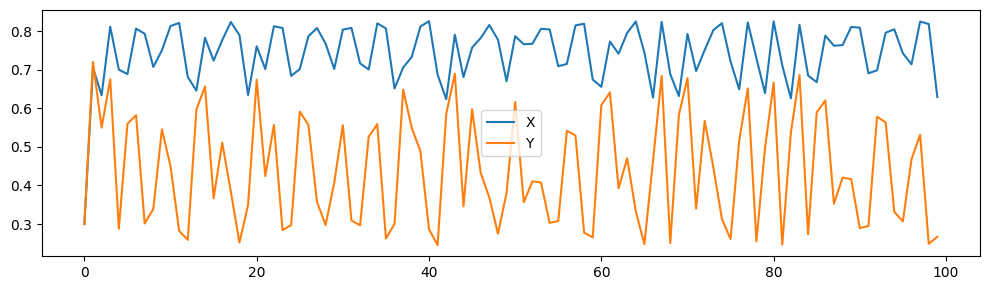

In [37]:
plt.figure(figsize=(10, 3))
plt.plot(X[:100], label="X")
plt.plot(Y[:100], label = "Y")
plt.legend()
plt.tight_layout()
plt.show()

CCM was able to infer the feedback loop between the two, but was unable to correctly order the causal relation by strength.

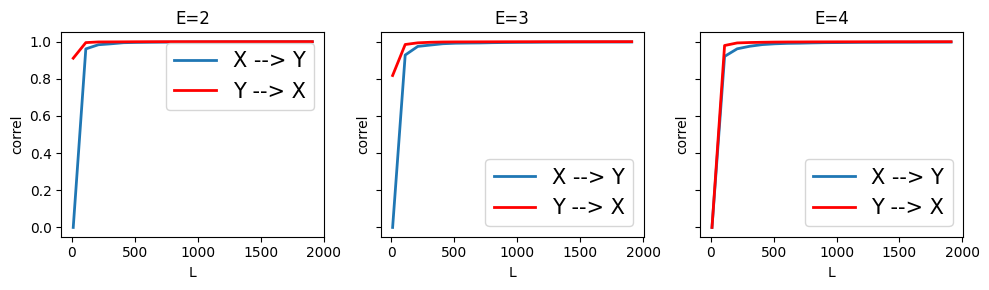

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, X, Y, L_range, tau, E, X_name='X', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()    

## Chaotic Models + Noise

We conduct the same experiments as above but we add independent random Gaussian noise on each variable.

### Example 1
Again, we define a coupled chaotic function among three time series $X$, $Y$, and $Z$. But only $X$ and $Y$ are observed. We visualize below the relationships among the variables. In this case, $Z_t \rightarrow X_{t+1}$ and $Z_t \rightarrow Y_{t+2}$ but there is no causal relation between $X$ and $Y$.

On top of this, we add random Gaussian noise per variable.

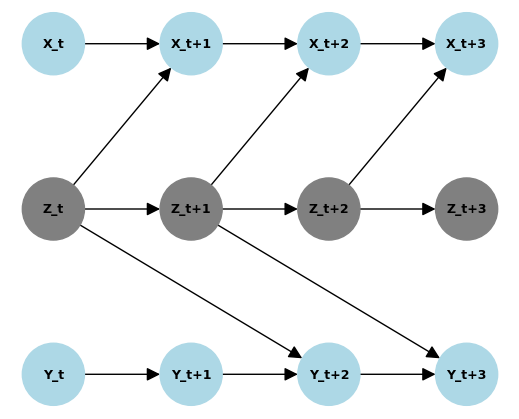

In [ ]:
# Create a new directed graph for the updated visualization
def draw():
    G = nx.DiGraph()

    # Re-adding nodes for time steps t to t+3
    # X and Y are visible, Z is hidden but without the "hidden" label
    nodes = ['X_t', 'X_t+1', 'X_t+2', 'X_t+3',
            'Y_t', 'Y_t+1', 'Y_t+2', 'Y_t+3',
            'Z_t', 'Z_t+1', 'Z_t+2', 'Z_t+3']

    # Re-adding directed edges according to the SCM
    edges = [
        # X time series
        ('X_t', 'X_t+1'), ('X_t+1', 'X_t+2'), ('X_t+2', 'X_t+3'),
        # Y time series
        ('Y_t', 'Y_t+1'), ('Y_t+1', 'Y_t+2'), ('Y_t+2', 'Y_t+3'),
        # Hidden Z time series
        ('Z_t', 'Z_t+1'), ('Z_t+1', 'Z_t+2'), ('Z_t+2', 'Z_t+3'),
        # Hidden Z affecting X and Y
        ('Z_t', 'X_t+1'), ('Z_t+1', 'X_t+2'), ('Z_t+2', 'X_t+3'),
        ('Z_t', 'Y_t+2'), ('Z_t+1', 'Y_t+3')
    ]

    # Add nodes and edges to the graph
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # Set positions to place Z nodes in the middle of X and Y, spaced out for time steps
    pos = {
        'X_t': (0, 3), 'X_t+1': (2, 3), 'X_t+2': (4, 3), 'X_t+3': (6, 3),
        'Y_t': (0, 1), 'Y_t+1': (2, 1), 'Y_t+2': (4, 1), 'Y_t+3': (6, 1),
        'Z_t': (0, 2), 'Z_t+1': (2, 2), 'Z_t+2': (4, 2), 'Z_t+3': (6, 2)
    }

    # Assign lighter blue for X and Y, gray for Z
    node_colors = ['lightblue' if 'X' in node or 'Y' in node else 'gray' for node in G.nodes]

    # Draw the graph with lighter blue for X and Y, gray for Z
    plt.figure(figsize=(5, 4))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=9, font_weight='bold', arrowsize=20)

    # Display the plot
    plt.show()

draw()

We use the same determinsitic coupled chaotic system as above, but we add a small Gaussian noise.

In [87]:
# params
r_x = 3.4
r_y = 3.6
r_z = 3.8
B_xy = 0.0 # effect on x given y (effect of y on x)
B_yx = 0.0 # effect on y given x (effect of x on y)
B_yz = 0.2 # effect of z on y
B_xz = 0.2 # effect of z on x

np.random.seed(42)
X_std = 0.015
Y_std = 0.015
Z_std = 0.015

X0 = 0.3 # initial val following Sugihara et al
Y0 = 0.3 # initial val following Sugihara et al
Z0 = 0.3
t = 2000 # time steps

X = [X0, X0]
Y = [Y0, Y0]
Z = [Z0, Z0]
for i in range(t):
    Z_ = chaotic_func(Z[-1], 0, r_z, 0) + np.random.normal(0, Z_std)   
    X_ = chaotic_func(X[-1], Z[-1], r_x, B_xz) + np.random.normal(0, X_std)   
    Y_ = chaotic_func(Y[-1], Z[-2], r_y, B_yz) + np.random.normal(0, Y_std)   
    X.append(X_)
    Y.append(Y_)
    Z.append(Z_)

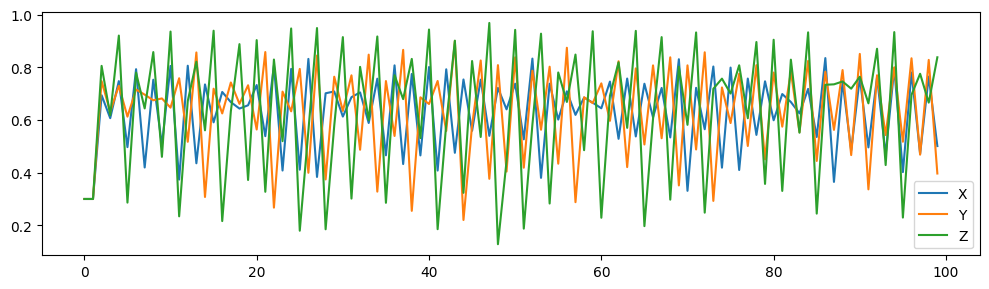

In [88]:
plt.figure(figsize=(10, 3))
plt.plot(X[:100], label="X")
plt.plot(Y[:100], label = "Y")
plt.plot(Z[:100], label = "Z")
plt.legend()
plt.tight_layout()
plt.show()

Once we added noise, CCM incorrectly infers that $X \rightarrow Y$. So now we see that when the dynamical system is not perfectly determinsitic, CCM fails. (Even when the Gaussian noise has a small standard deviation = 0.015). This may be a problem since we expect real world dynamical systems to have some randomness.

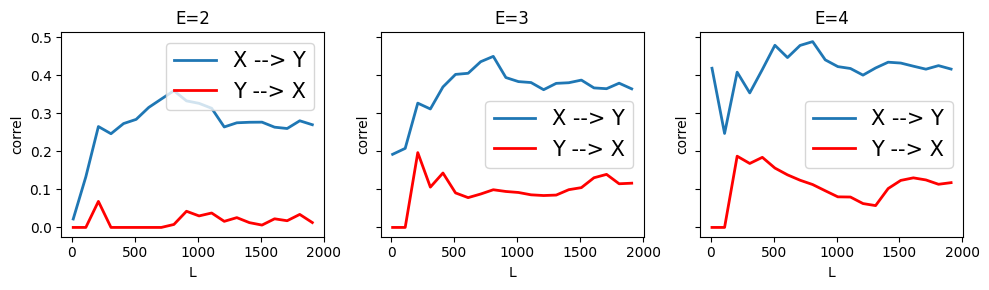

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, X, Y, L_range, tau, E, X_name='X', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()

Can CCM infer that $Z \rightarrow X$? We can see below that yes, it still can.

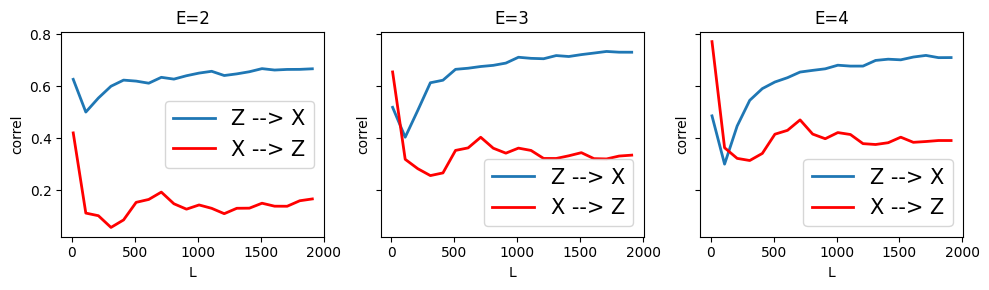

In [90]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, Z, X, L_range, tau, E, X_name='Z', Y_name='X', ax=axs[i])
plt.tight_layout()
plt.show()    

Similarly, CCM can still infer that $Z \rightarrow Y$. But it seems that CCM infers a small $Y \rightarrow Z$ which is incorrect.

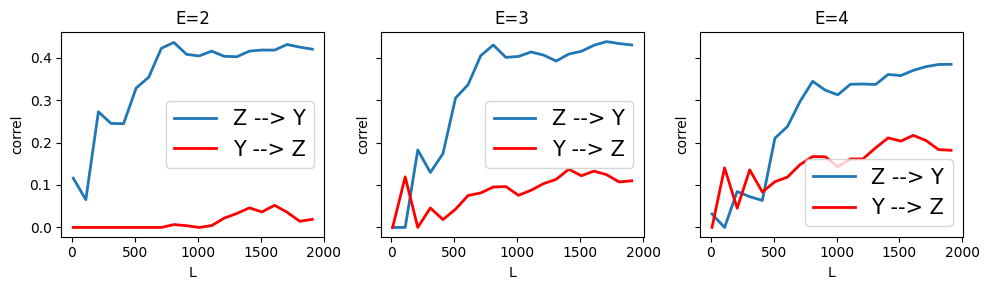

In [91]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, Z, Y, L_range, tau, E, X_name='Z', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()    

### Example 2

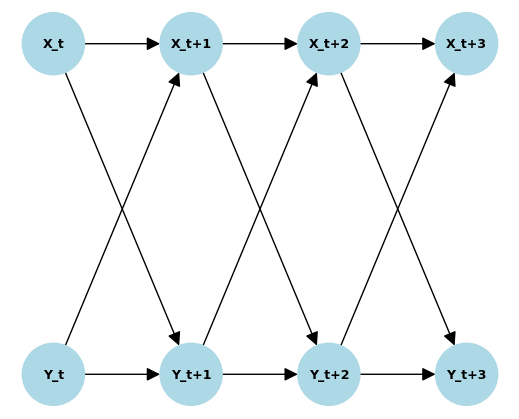

In [117]:
def draw():

    # Create a new directed graph with additional self-dependencies for X and Y
    G_modified = nx.DiGraph()

    # Re-adding nodes for time steps t to t+3 for X and Y
    nodes_modified = ['X_t', 'X_t+1', 'X_t+2', 'X_t+3',
                    'Y_t', 'Y_t+1', 'Y_t+2', 'Y_t+3']

    # Adding directed edges according to the modified relations for t to t+3
    edges_modified = [
        # X to Y relations
        ('X_t', 'Y_t+1'), ('X_t+1', 'Y_t+2'), ('X_t+2', 'Y_t+3'),
        # Y to X relations
        ('Y_t', 'X_t+1'), ('Y_t+1', 'X_t+2'), ('Y_t+2', 'X_t+3'),
        # Self-dependencies for X and Y
        ('X_t', 'X_t+1'), ('X_t+1', 'X_t+2'), ('X_t+2', 'X_t+3'),
        ('Y_t', 'Y_t+1'), ('Y_t+1', 'Y_t+2'), ('Y_t+2', 'Y_t+3')
    ]

    # Add nodes and edges to the graph
    G_modified.add_nodes_from(nodes_modified)
    G_modified.add_edges_from(edges_modified)

    # Set positions for a clearer layout, spaced out for time steps
    pos_modified = {
        'X_t': (0, 2), 'X_t+1': (2, 2), 'X_t+2': (4, 2), 'X_t+3': (6, 2),
        'Y_t': (0, 1), 'Y_t+1': (2, 1), 'Y_t+2': (4, 1), 'Y_t+3': (6, 1)
    }

    # Assign colors: blue for both X and Y
    node_colors_modified = ['lightblue' for node in G_modified.nodes]

    # Draw the modified graph with additional self-dependencies
    plt.figure(figsize=(5, 4))
    nx.draw(G_modified, pos_modified, with_labels=True, node_size=2000, node_color=node_colors_modified, font_size=9, font_weight='bold', arrowsize=20)

    # Display the plot
    plt.show()

draw()

In [124]:
# params
r_x = 3.4
r_y = 3.6
B_xy = 0.1 # effect on x given y (effect of y on x)
B_yx = 0.4 # effect on y given x (effect of x on y)

np.random.seed(42)
X_std = 0.015
Y_std = 0.015

X0 = 0.3 # initial val following Sugihara et al
Y0 = 0.3 # initial val following Sugihara et al
t = 2000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = chaotic_func(X[-1], Y[-1], r_x, B_xy) + np.random.normal(0, X_std)
    Y_ = chaotic_func(Y[-1], X[-1], r_y, B_yx) + np.random.normal(0, Y_std)
    X.append(X_)
    Y.append(Y_)

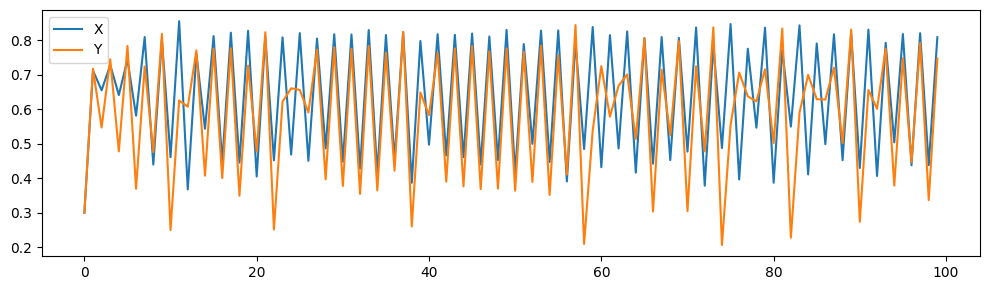

In [125]:
plt.figure(figsize=(10, 3))
plt.plot(X[:100], label="X")
plt.plot(Y[:100], label = "Y")
plt.legend()
plt.tight_layout()
plt.show()

Here we find that CCM was able to correctly infer $X \rightarrow Y$ and some weaker $Y \rightarrow X$

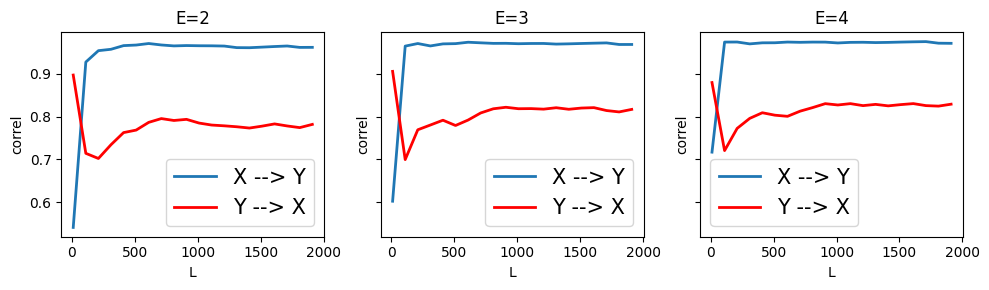

In [126]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, X, Y, L_range, tau, E, X_name='X', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()    

### Example 3

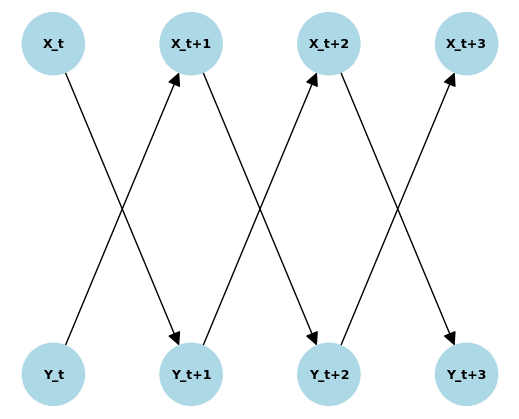

In [127]:
def draw():
    # Create a new directed graph for the extended time range t to t+3
    G_extended = nx.DiGraph()

    # Re-adding nodes for time steps t to t+3 for X and Y
    nodes_extended = ['X_t', 'X_t+1', 'X_t+2', 'X_t+3',
                    'Y_t', 'Y_t+1', 'Y_t+2', 'Y_t+3']

    # Adding directed edges according to the relations for t to t+3
    edges_extended = [
        # X to Y relations
        ('X_t', 'Y_t+1'), ('X_t+1', 'Y_t+2'), ('X_t+2', 'Y_t+3'),
        # Y to X relations
        ('Y_t', 'X_t+1'), ('Y_t+1', 'X_t+2'), ('Y_t+2', 'X_t+3')
    ]

    # Add nodes and edges to the graph
    G_extended.add_nodes_from(nodes_extended)
    G_extended.add_edges_from(edges_extended)

    # Set positions for a clearer layout, spaced out for time steps
    pos_extended = {
        'X_t': (0, 2), 'X_t+1': (2, 2), 'X_t+2': (4, 2), 'X_t+3': (6, 2),
        'Y_t': (0, 1), 'Y_t+1': (2, 1), 'Y_t+2': (4, 1), 'Y_t+3': (6, 1)
    }

    # Assign colors: blue for both X and Y
    node_colors_extended = ['lightblue' for node in G_extended.nodes]

    # Draw the extended graph
    plt.figure(figsize=(5, 4))
    nx.draw(G_extended, pos_extended, with_labels=True, node_size=2000, node_color=node_colors_extended, font_size=9, font_weight='bold', arrowsize=20)

    # Display the plot
    plt.show()

draw()

In [130]:
# params
r_x = 3.4
r_y = 3.6
B_xy = 0.1 # effect on x given y (effect of y on x)
B_yx = 0.4 # effect on y given x (effect of x on y)

X_std = 0.015
Y_std = 0.015

X0 = 0.3 # initial val following Sugihara et al
Y0 = 0.3 # initial val following Sugihara et al
t = 2000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = chaotic_func(Y[-1], Y[-1], r_x, B_xy) + np.random.normal(0, X_std)
    Y_ = chaotic_func(X[-1], X[-1], r_y, B_yx) + np.random.normal(0, Y_std)
    X.append(X_)
    Y.append(Y_)

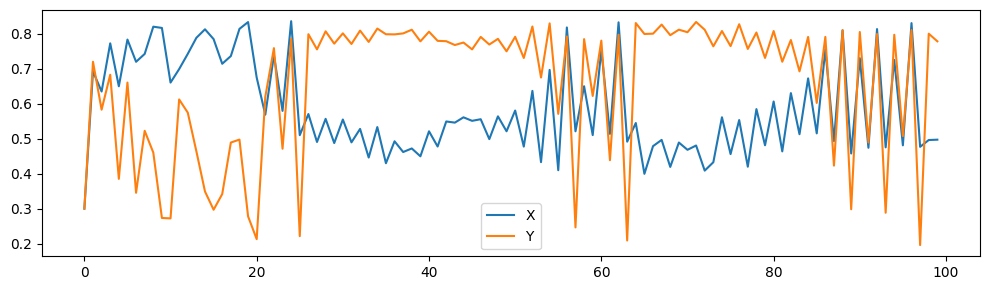

In [134]:
plt.figure(figsize=(10, 3))
plt.plot(X[:100], label="X")
plt.plot(Y[:100], label = "Y")
plt.legend()
plt.tight_layout()
plt.show()

CCM was able to infer the feedback loop between the two, but was unable to correctly order the causal relation by strength.

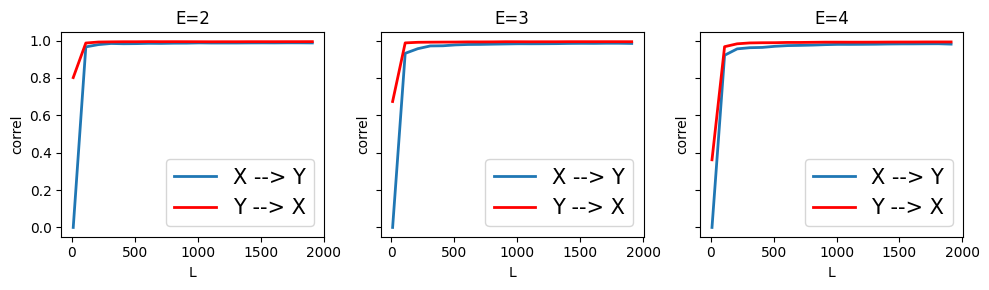

In [132]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, X, Y, L_range, tau, E, X_name='X', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()    

## Additive Noise Models

Additive Noise Models (ANMs) follow this general mathematical form: $Y = f(X) + N_X$ where $N_X$ is independent noise.

### Example 1

We still follow the same causal graph as Example 1 in the chaotic function class above. However, instead of a chaotic relationship between variables, we use ANM formulation. Based on the insights above on chaotic models with noise (essentially it no longer becomes chaotic technically since chaotic systems are deterministic), we may hypothesize that CCM will fail on ANMs as well.

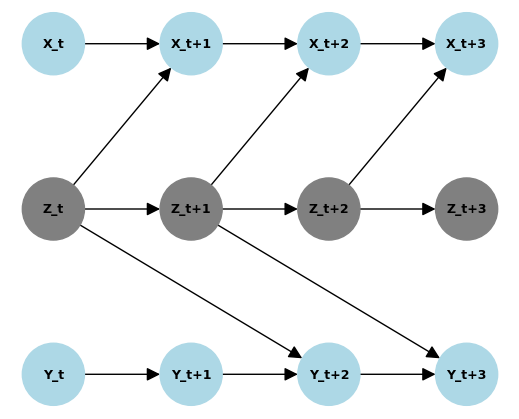

In [92]:
# Create a new directed graph for the updated visualization
def draw():
    G = nx.DiGraph()

    # Re-adding nodes for time steps t to t+3
    # X and Y are visible, Z is hidden but without the "hidden" label
    nodes = ['X_t', 'X_t+1', 'X_t+2', 'X_t+3',
            'Y_t', 'Y_t+1', 'Y_t+2', 'Y_t+3',
            'Z_t', 'Z_t+1', 'Z_t+2', 'Z_t+3']

    # Re-adding directed edges according to the SCM
    edges = [
        # X time series
        ('X_t', 'X_t+1'), ('X_t+1', 'X_t+2'), ('X_t+2', 'X_t+3'),
        # Y time series
        ('Y_t', 'Y_t+1'), ('Y_t+1', 'Y_t+2'), ('Y_t+2', 'Y_t+3'),
        # Hidden Z time series
        ('Z_t', 'Z_t+1'), ('Z_t+1', 'Z_t+2'), ('Z_t+2', 'Z_t+3'),
        # Hidden Z affecting X and Y
        ('Z_t', 'X_t+1'), ('Z_t+1', 'X_t+2'), ('Z_t+2', 'X_t+3'),
        ('Z_t', 'Y_t+2'), ('Z_t+1', 'Y_t+3')
    ]

    # Add nodes and edges to the graph
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # Set positions to place Z nodes in the middle of X and Y, spaced out for time steps
    pos = {
        'X_t': (0, 3), 'X_t+1': (2, 3), 'X_t+2': (4, 3), 'X_t+3': (6, 3),
        'Y_t': (0, 1), 'Y_t+1': (2, 1), 'Y_t+2': (4, 1), 'Y_t+3': (6, 1),
        'Z_t': (0, 2), 'Z_t+1': (2, 2), 'Z_t+2': (4, 2), 'Z_t+3': (6, 2)
    }

    # Assign lighter blue for X and Y, gray for Z
    node_colors = ['lightblue' if 'X' in node or 'Y' in node else 'gray' for node in G.nodes]

    # Draw the graph with lighter blue for X and Y, gray for Z
    plt.figure(figsize=(5, 4))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=9, font_weight='bold', arrowsize=20)

    # Display the plot
    plt.show()

draw()

In [96]:
# create a time series SCM
np.random.seed(42)
L = 2000
alpha = 0.5
beta = 0.2
X_std = 0.1
Y_std = 0.1
Z_std = 0.1
X = [np.random.normal(0, X_std), np.random.normal(0, X_std)]
Y = [np.random.normal(0, Y_std), np.random.normal(0, Y_std)]
Z = [np.random.normal(0, Z_std), np.random.normal(0, Z_std)]
for t in range(L):
    X += [alpha * X[-1] + beta * Z[-1] + np.random.normal(0, X_std)]
    Y += [alpha * Y[-1] + beta * Z[-2] + np.random.normal(0, Y_std)]
    Z += [alpha * Z[-1] + np.random.normal(0, Z_std)]

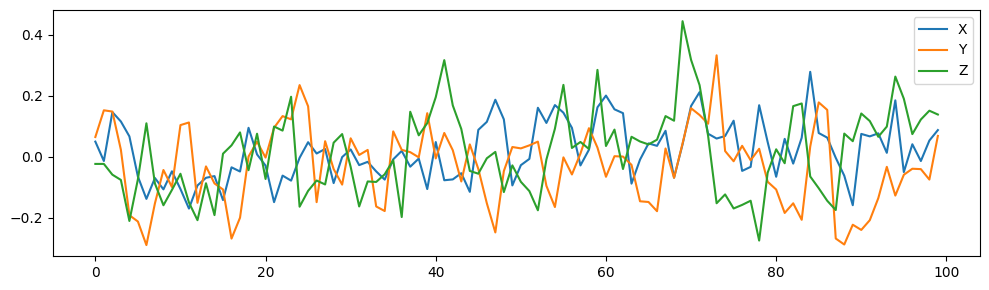

In [97]:
plt.figure(figsize=(10, 3))
plt.plot(X[:100], label="X")
plt.plot(Y[:100], label = "Y")
plt.plot(Z[:100], label = "Z")
plt.legend()
plt.tight_layout()
plt.show()

Interestingly, CCM correctly infers that there is not causal link between $X$ and $Y$

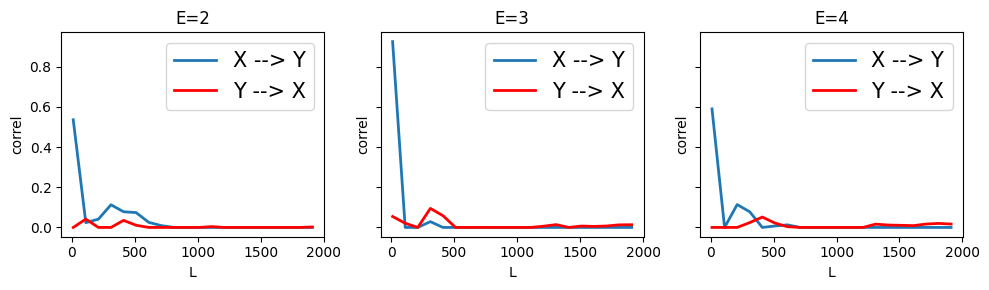

In [98]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, X, Y, L_range, tau, E, X_name='X', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()    

However, CCM incorrectly infers a weak causal link $X \rightarrow Z$ which is the opposite of the actual relation for embedding dimension, E=4. For E=2 and E=3, CCM does not infer any causal effect.

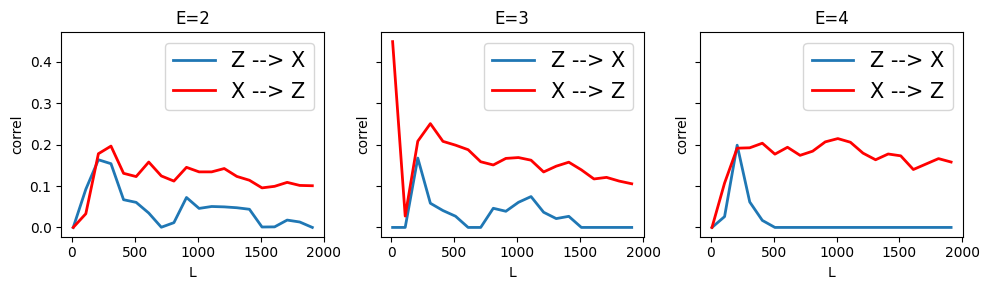

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, Z, X, L_range, tau, E, X_name='Z', Y_name='X', ax=axs[i])
plt.tight_layout()
plt.show()    

Similarly, CCM incorrectly infers a weak causal link $Y \rightarrow Z$ for E=4, which is the opposite of the actual relation.

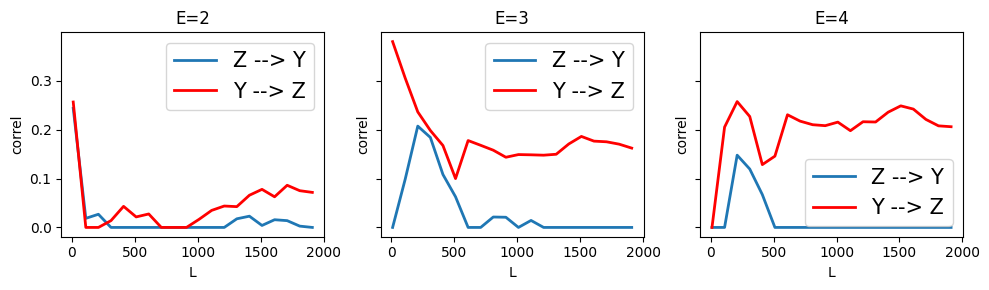

In [100]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, Z, Y, L_range, tau, E, X_name='Z', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()    

### Example 2

Again this is the same causal graph as Example 2 above, but we use ANMs as the functional relations among variables instead of a chaotic function.

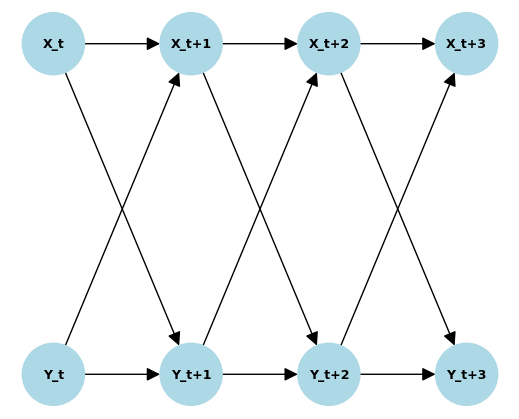

In [101]:
def draw():

    # Create a new directed graph with additional self-dependencies for X and Y
    G_modified = nx.DiGraph()

    # Re-adding nodes for time steps t to t+3 for X and Y
    nodes_modified = ['X_t', 'X_t+1', 'X_t+2', 'X_t+3',
                    'Y_t', 'Y_t+1', 'Y_t+2', 'Y_t+3']

    # Adding directed edges according to the modified relations for t to t+3
    edges_modified = [
        # X to Y relations
        ('X_t', 'Y_t+1'), ('X_t+1', 'Y_t+2'), ('X_t+2', 'Y_t+3'),
        # Y to X relations
        ('Y_t', 'X_t+1'), ('Y_t+1', 'X_t+2'), ('Y_t+2', 'X_t+3'),
        # Self-dependencies for X and Y
        ('X_t', 'X_t+1'), ('X_t+1', 'X_t+2'), ('X_t+2', 'X_t+3'),
        ('Y_t', 'Y_t+1'), ('Y_t+1', 'Y_t+2'), ('Y_t+2', 'Y_t+3')
    ]

    # Add nodes and edges to the graph
    G_modified.add_nodes_from(nodes_modified)
    G_modified.add_edges_from(edges_modified)

    # Set positions for a clearer layout, spaced out for time steps
    pos_modified = {
        'X_t': (0, 2), 'X_t+1': (2, 2), 'X_t+2': (4, 2), 'X_t+3': (6, 2),
        'Y_t': (0, 1), 'Y_t+1': (2, 1), 'Y_t+2': (4, 1), 'Y_t+3': (6, 1)
    }

    # Assign colors: blue for both X and Y
    node_colors_modified = ['lightblue' for node in G_modified.nodes]

    # Draw the modified graph with additional self-dependencies
    plt.figure(figsize=(5, 4))
    nx.draw(G_modified, pos_modified, with_labels=True, node_size=2000, node_color=node_colors_modified, font_size=9, font_weight='bold', arrowsize=20)

    # Display the plot
    plt.show()

draw()

In [102]:
# create a time series SCM
np.random.seed(42)
L = 2000
alpha = 0.5
beta = 0.2
X_std = 0.1
Y_std = 0.1
X = [np.random.normal(0, X_std), np.random.normal(0, X_std)]
Y = [np.random.normal(0, Y_std), np.random.normal(0, Y_std)]
for t in range(L):
    X += [alpha * X[-1] + beta * Y[-1] + np.random.normal(0, X_std)]
    Y += [alpha * Y[-1] + beta * X[-1] + np.random.normal(0, Y_std)]

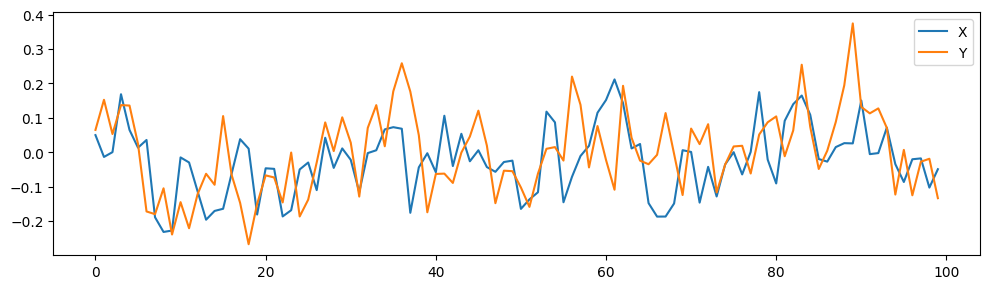

In [103]:
plt.figure(figsize=(10, 3))
plt.plot(X[:100], label="X")
plt.plot(Y[:100], label = "Y")
plt.legend()
plt.tight_layout()
plt.show()

Unfortunately CCM does not infer any causal relation, which is incorrect.

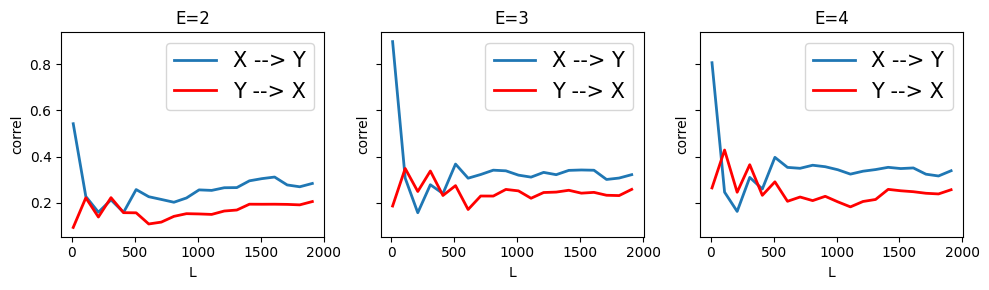

In [104]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, X, Y, L_range, tau, E, X_name='X', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()    

### Example 3
Here, we make the effect of $X$ on $Y$ stronger than $Y$ on $X$.

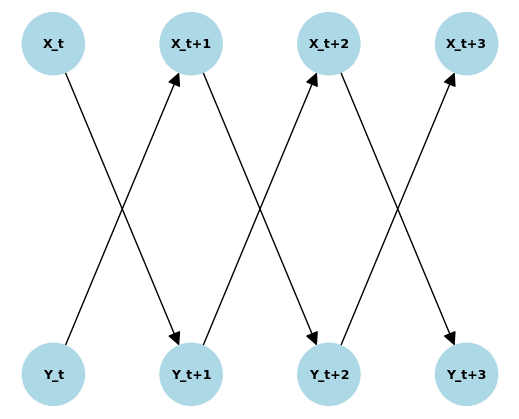

In [109]:
def draw():
    # Create a new directed graph for the extended time range t to t+3
    G_extended = nx.DiGraph()

    # Re-adding nodes for time steps t to t+3 for X and Y
    nodes_extended = ['X_t', 'X_t+1', 'X_t+2', 'X_t+3',
                    'Y_t', 'Y_t+1', 'Y_t+2', 'Y_t+3']

    # Adding directed edges according to the relations for t to t+3
    edges_extended = [
        # X to Y relations
        ('X_t', 'Y_t+1'), ('X_t+1', 'Y_t+2'), ('X_t+2', 'Y_t+3'),
        # Y to X relations
        ('Y_t', 'X_t+1'), ('Y_t+1', 'X_t+2'), ('Y_t+2', 'X_t+3')
    ]

    # Add nodes and edges to the graph
    G_extended.add_nodes_from(nodes_extended)
    G_extended.add_edges_from(edges_extended)

    # Set positions for a clearer layout, spaced out for time steps
    pos_extended = {
        'X_t': (0, 2), 'X_t+1': (2, 2), 'X_t+2': (4, 2), 'X_t+3': (6, 2),
        'Y_t': (0, 1), 'Y_t+1': (2, 1), 'Y_t+2': (4, 1), 'Y_t+3': (6, 1)
    }

    # Assign colors: blue for both X and Y
    node_colors_extended = ['lightblue' for node in G_extended.nodes]

    # Draw the extended graph
    plt.figure(figsize=(5, 4))
    nx.draw(G_extended, pos_extended, with_labels=True, node_size=2000, node_color=node_colors_extended, font_size=9, font_weight='bold', arrowsize=20)

    # Display the plot
    plt.show()

draw()

In [110]:
# create a time series SCM
np.random.seed(42)
L = 2000
alpha = 0.5
beta = 0.1
X_std = 0.1
Y_std = 0.1
X = [np.random.normal(0, X_std), np.random.normal(0, X_std)]
Y = [np.random.normal(0, Y_std), np.random.normal(0, Y_std)]
for t in range(L):
    X += [beta * Y[-1] + np.random.normal(0, X_std)]
    Y += [alpha * X[-1] + np.random.normal(0, Y_std)]

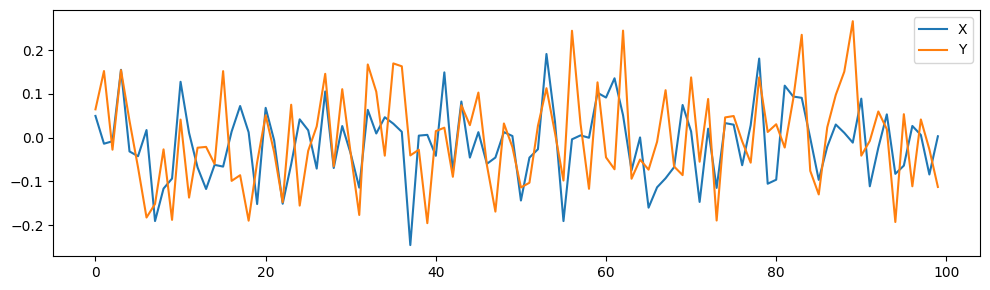

In [111]:
plt.figure(figsize=(10, 3))
plt.plot(X[:100], label="X")
plt.plot(Y[:100], label = "Y")
plt.legend()
plt.tight_layout()
plt.show()

CCM correctly infers the bidirectional causal relation with a stronger $X \rightarrow Y$ than $Y \rightarrow X$

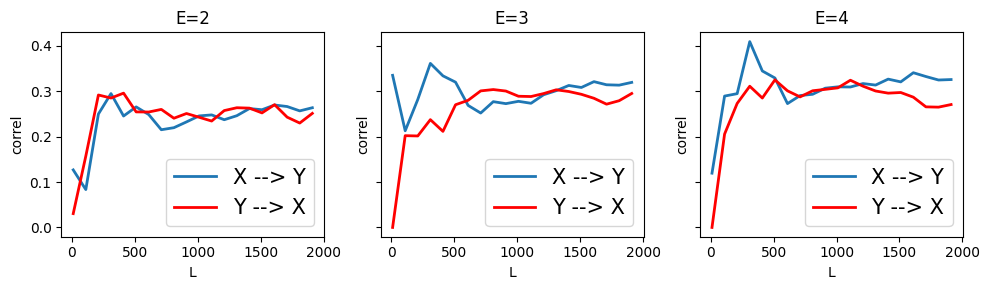

In [112]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(10, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, X, Y, L_range, tau, E, X_name='X', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()    

## Chaotic System in the Original CCM Paper (Sugihara, et al, 2012)

In [139]:
# FROM Supplementary Materials https://www.science.org/doi/10.1126/science.1227079
# params
r_x = 3.8
r_y = 3.5
B_xy = 0.02 # effect on x given y (effect of y on x)
B_yx = 0.1 # effect on y given x (effect of x on y)

X0 = 0.4 # initial val following Sugihara et al
Y0 = 0.2 # initial val following Sugihara et al
t = 3000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = chaotic_func(X[-1], Y[-1], r_x, B_xy)
    Y_ = chaotic_func(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)

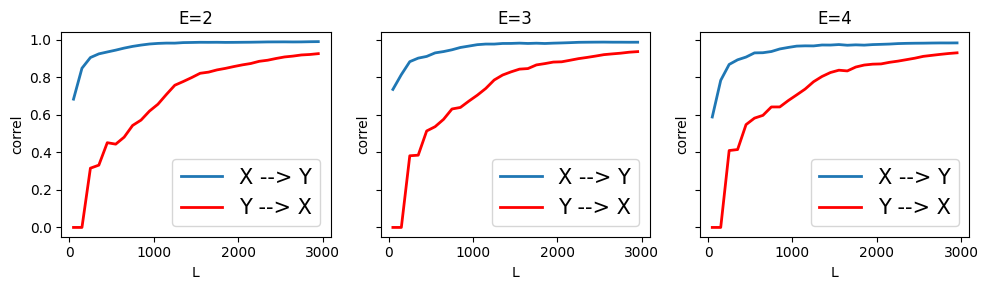

In [141]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, E in enumerate(range(2, 5)):
    L_range = range(50, len(X), 100) # L values to test
    tau = 1
    viz_ccm(ccm, X, Y, L_range, tau, E, X_name='X', Y_name='Y', ax=axs[i])
plt.tight_layout()
plt.show()    